# Product Review Classification

## Business Understanding
Our company wants a tool that will automatically classify product reviews as _positive_ or _negative_ reviews, based on the features of the review.  This will help our Product team to perform more sophisticated analyses in the future to help ensure customer satisfaction.

## Data Understanding
We have a labeled collection of 20,000 product reviews, with an equal split of positive and negative reviews. The dataset contains the following features:

 - `ProductId` Unique identifier for the product
 - `UserId` Unqiue identifier for the user
 - `ProfileName` Profile name of the user
 - `HelpfulnessNumerator` Number of users who found the review helpful
 - `HelpfulnessDenominator` Number of users who indicated whether they found the review helpful or not
 - `Time` Timestamp for the review
 - `Summary` Brief summary of the review
 - `Text` Text of the review
 - `PositiveReview` 1 if this was labeled as a positive review, 0 if it was labeled as a negative review

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [2]:
df = pd.read_csv("reviews.csv")
df.head(3)

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,PositiveReview
0,B002QWHJOU,A37565LZHTG1VH,C. Maltese,1,1,1305331200,Awesome!,This is a great product. My 2 year old Golden ...,1
1,B000ESLJ6C,AMUAWXDJHE4D2,angieseashore,1,1,1320710400,Was there a recipe change?,I have been drinking Pero ever since I was a l...,0
2,B004IJJQK4,AMHHNAFJ9L958,A M,0,1,1321747200,These taste so bland.,"Look, each pack contains two servings of 120 c...",0


The data has already been cleaned, so there are no missing values

In [3]:
df.isna().sum()

ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Time                      0
Summary                   0
Text                      0
PositiveReview            0
dtype: int64

`PositiveReview` is the target, and all other columns are features

In [4]:
X = df.drop("PositiveReview", axis=1)
y = df["PositiveReview"]

## Data Preparation

First, split into train and test sets

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.shape

(15000, 8)

Second, prepare for modeling. The following `Pipeline` prepares all data for modeling.  It one-hot encodes the `ProductId`, applies a tf-idf vectorizer to the `Summary` and `Text`, keeps the numeric columns as-is, and drops all other columns.

The following code may take up to 1 minute to run.

In [26]:
def drop_irrelevant_columns(X):
    return X.drop(["UserId", "ProfileName"], axis=1)

pipeline = Pipeline(steps=[
    ("drop_columns", FunctionTransformer(drop_irrelevant_columns)),
    ("transform_text_columns", ColumnTransformer(transformers=[
        ("ohe", OneHotEncoder(categories="auto", handle_unknown="ignore", sparse=False), ["ProductId"]),
        ("summary-tf-idf", TfidfVectorizer(max_features=1000), "Summary"),
        ("text-tf-idf", TfidfVectorizer(max_features=1000), "Text")
    ], remainder="passthrough"))
])

X_train_transformed = pipeline.fit_transform(X_train)
X_test_transformed = pipeline.transform(X_test)

X_train_transformed.shape

(15000, 11275)

## Modeling

Fit a `RandomForestClassifier` with the best hyperparameters.  The following code may take up to 1 minute to run.

In [7]:
rfc = RandomForestClassifier(
    random_state=42,
    n_estimators=100,
    max_depth=30,
    min_samples_split=15,
    min_samples_leaf=1
)
rfc.fit(X_train_transformed, y_train)

RandomForestClassifier(max_depth=30, min_samples_split=15, random_state=42)

## Model Evaluation

We are using _accuracy_ as our metric, which is the default metric in Scikit-Learn, so it is possible to just use the built-in `.score` method

In [8]:
print("Train accuracy:", rfc.score(X_train_transformed, y_train))
print("Test accuracy:", rfc.score(X_test_transformed, y_test))

Train accuracy: 0.9826666666666667
Test accuracy: 0.913


In [12]:
print("Train confusion matrix:")
print(confusion_matrix(y_train, rfc.predict(X_train_transformed)))
print("Test confusion matrix:")
print(confusion_matrix(y_test, rfc.predict(X_test_transformed)))

Train confusion matrix:
[[7312  177]
 [  83 7428]]
Test confusion matrix:
[[2293  218]
 [ 217 2272]]


## Business Interpretation

The tuned Random Forest Classifier model appears to be somewhat overfit on the training data, but nevertheless achieves 91% accuracy on the test data.  Of the 9% of mislabeled comments, about half are false positives and half are false negatives.

Because this is a balanced dataset, 91% accuracy is a substantial improvement over a 50% baseline.  This model is ready for production use for decision support.

## Preprocess Data

In [14]:
# import
from sklearn.preprocessing import StandardScaler

In [27]:
# # instantiate, fit standard scaler on train data
# ss = StandardScaler()
# ss.fit(X_train_transformed)

# # transform train data
# X_train_sc = ss.transform(X_train_transformed)


In [34]:
# create pipeline with standard scaler
pipeline_sc = Pipeline(steps=[
    ("drop_columns", FunctionTransformer(drop_irrelevant_columns)),
    ("transform_text_columns", ColumnTransformer(transformers=[
        ("ohe", OneHotEncoder(categories="auto", handle_unknown="ignore", sparse=False), ["ProductId"]),
        ("summary-tf-idf", TfidfVectorizer(max_features=1000), "Summary"),
        ("text-tf-idf", TfidfVectorizer(max_features=1000), "Text")], remainder="passthrough")),
    ('scale', StandardScaler())])

X_train_transformed_scaled = pipeline_sc.fit_transform(X_train)
X_test_transformed_scaled = pipeline_sc.transform(X_test)

X_train_transformed_scaled.shape

(15000, 11275)

## Model

In [60]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.callbacks import EarlyStopping

In [99]:
model0 = Sequential()
model0.add(Dense(64, input_shape=(11275,), activation='tanh'))
model0.add(Dense(32, activation='relu'))
model0.add(Dense(16, activation='sigmoid'))
model0.add(Dense(1, activation='sigmoid'))


early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-9, patience=6, verbose=1,
                           mode='min')
model0.compile(optimizer='Adamax', loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-20, patience=6, verbose=1,
                           mode='min')
results = model0.fit(X_train_transformed_scaled, y_train, validation_split=0.1, epochs=50) #, callbacks=[early_stop])

Epoch 1/50
422/422 [==============================] - 3s 8ms/step - loss: 0.4533 - accuracy: 0.8164 - val_loss: 0.3191 - val_accuracy: 0.8667
Epoch 2/50
422/422 [==============================] - 3s 7ms/step - loss: 0.1864 - accuracy: 0.9359 - val_loss: 0.2186 - val_accuracy: 0.9213
Epoch 3/50
422/422 [==============================] - 3s 6ms/step - loss: 0.0987 - accuracy: 0.9716 - val_loss: 0.2118 - val_accuracy: 0.9220
Epoch 4/50
422/422 [==============================] - 3s 7ms/step - loss: 0.0555 - accuracy: 0.9879 - val_loss: 0.2152 - val_accuracy: 0.9200
Epoch 5/50
422/422 [==============================] - 3s 7ms/step - loss: 0.0342 - accuracy: 0.9939 - val_loss: 0.2230 - val_accuracy: 0.9193
Epoch 6/50
422/422 [==============================] - 3s 6ms/step - loss: 0.0227 - accuracy: 0.9966 - val_loss: 0.2407 - val_accuracy: 0.9133
Epoch 7/50
422/422 [==============================] - 3s 6ms/step - loss: 0.0169 - accuracy: 0.9976 - val_loss: 0.2409 - val_accuracy: 0.9167
Epoch 

## Tune Model

In [94]:
model1 = Sequential()
model1.add(Dense(64, input_shape=(11275,), activation='tanh'))
model1.add(Dense(32, activation='relu'))
model1.add(Dense(16, activation='sigmoid'))
model1.add(Dense(1, activation='sigmoid'))

model1.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

results = model1.fit(X_train_transformed_scaled, y_train, validation_split=0.1, epochs=50, callbacks=[early_stop])

Epoch 1/50
422/422 [==============================] - 3s 7ms/step - loss: 0.3352 - accuracy: 0.8644 - val_loss: 0.2162 - val_accuracy: 0.9167
Epoch 2/50
422/422 [==============================] - 3s 6ms/step - loss: 0.0786 - accuracy: 0.9803 - val_loss: 0.2322 - val_accuracy: 0.9153
Epoch 3/50
422/422 [==============================] - 3s 7ms/step - loss: 0.0275 - accuracy: 0.9939 - val_loss: 0.2781 - val_accuracy: 0.9100
Epoch 4/50
422/422 [==============================] - 3s 6ms/step - loss: 0.0132 - accuracy: 0.9975 - val_loss: 0.2918 - val_accuracy: 0.9147
Epoch 5/50
422/422 [==============================] - 3s 6ms/step - loss: 0.0076 - accuracy: 0.9990 - val_loss: 0.3205 - val_accuracy: 0.9133
Epoch 6/50
422/422 [==============================] - 2s 6ms/step - loss: 0.0050 - accuracy: 0.9996 - val_loss: 0.3411 - val_accuracy: 0.9107
Epoch 7/50
422/422 [==============================] - 3s 6ms/step - loss: 0.0037 - accuracy: 0.9997 - val_loss: 0.3582 - val_accuracy: 0.9153
Epoch 

In [93]:
model2 = Sequential()
model2.add(Dense(64, input_shape=(11275,), activation='relu'))
model2.add(Dense(32, activation='selu'))
model2.add(Dense(16, activation='tanh'))
model2.add(Dense(1, activation='sigmoid'))

model2.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])


results = model2.fit(X_train_transformed_scaled, y_train, validation_split=0.1, epochs=50, callbacks=[early_stop])

Epoch 1/50
422/422 [==============================] - 3s 7ms/step - loss: 0.3030 - accuracy: 0.8676 - val_loss: 0.2162 - val_accuracy: 0.9160
Epoch 2/50
422/422 [==============================] - 3s 6ms/step - loss: 0.0527 - accuracy: 0.9841 - val_loss: 0.2435 - val_accuracy: 0.9187
Epoch 3/50
422/422 [==============================] - 3s 7ms/step - loss: 0.0169 - accuracy: 0.9952 - val_loss: 0.2741 - val_accuracy: 0.9193
Epoch 4/50
422/422 [==============================] - 3s 6ms/step - loss: 0.0076 - accuracy: 0.9982 - val_loss: 0.3114 - val_accuracy: 0.9093
Epoch 5/50
422/422 [==============================] - 3s 6ms/step - loss: 0.0041 - accuracy: 0.9994 - val_loss: 0.3443 - val_accuracy: 0.9140
Epoch 6/50
422/422 [==============================] - 3s 6ms/step - loss: 0.0031 - accuracy: 0.9996 - val_loss: 0.3608 - val_accuracy: 0.9127
Epoch 7/50
422/422 [==============================] - 3s 6ms/step - loss: 0.0023 - accuracy: 0.9998 - val_loss: 0.3782 - val_accuracy: 0.9133
Epoch 

In [96]:
model3 = Sequential()
model3.add(Dense(64, input_shape=(11275,), activation='tanh'))
model3.add(Dense(32, activation='sigmoid'))
model3.add(Dense(16, activation='tanh'))
model3.add(Dense(1, activation='sigmoid'))

model3.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

results = model3.fit(X_train_transformed_scaled, y_train, validation_split=0.1, epochs=50, callbacks=[early_stop])

Epoch 1/50
422/422 [==============================] - 3s 6ms/step - loss: 0.2906 - accuracy: 0.8850 - val_loss: 0.2098 - val_accuracy: 0.9167
Epoch 2/50
422/422 [==============================] - 2s 6ms/step - loss: 0.0525 - accuracy: 0.9841 - val_loss: 0.2306 - val_accuracy: 0.9147
Epoch 3/50
422/422 [==============================] - 2s 6ms/step - loss: 0.0219 - accuracy: 0.9938 - val_loss: 0.2578 - val_accuracy: 0.9140
Epoch 4/50
422/422 [==============================] - 3s 6ms/step - loss: 0.0087 - accuracy: 0.9979 - val_loss: 0.2804 - val_accuracy: 0.9180
Epoch 5/50
422/422 [==============================] - 2s 6ms/step - loss: 0.0046 - accuracy: 0.9988 - val_loss: 0.3127 - val_accuracy: 0.9173
Epoch 6/50
422/422 [==============================] - 2s 6ms/step - loss: 0.0039 - accuracy: 0.9993 - val_loss: 0.3506 - val_accuracy: 0.9100
Epoch 7/50
422/422 [==============================] - 3s 6ms/step - loss: 0.0023 - accuracy: 0.9996 - val_loss: 0.3806 - val_accuracy: 0.9087
Epoch 

In [86]:
model4 = Sequential()
model4.add(Dense(64, input_shape=(11275,), activation='tanh'))
model4.add(Dense(64, activation='sigmoid'))
model4.add(Dense(64, activation='tanh'))
model4.add(Dense(1, activation='sigmoid'))

model4.compile(optimizer='Adamax', loss='binary_crossentropy', metrics=['accuracy'])

results = model4.fit(X_train_transformed_scaled, y_train, validation_split=0.1, epochs=50, callbacks=[early_stop])

Epoch 1/50
422/422 [==============================] - 3s 7ms/step - loss: 0.3496 - accuracy: 0.8525 - val_loss: 0.2154 - val_accuracy: 0.9133
Epoch 2/50
422/422 [==============================] - 3s 7ms/step - loss: 0.1282 - accuracy: 0.9530 - val_loss: 0.2044 - val_accuracy: 0.9240
Epoch 3/50
422/422 [==============================] - 3s 6ms/step - loss: 0.0643 - accuracy: 0.9804 - val_loss: 0.2537 - val_accuracy: 0.9100
Epoch 4/50
422/422 [==============================] - 3s 6ms/step - loss: 0.0315 - accuracy: 0.9925 - val_loss: 0.2456 - val_accuracy: 0.9207
Epoch 5/50
422/422 [==============================] - 3s 6ms/step - loss: 0.0150 - accuracy: 0.9968 - val_loss: 0.3095 - val_accuracy: 0.9113
Epoch 00005: early stopping


In [90]:
model5 = Sequential()
model5.add(Dense(64, input_shape=(11275,), activation='tanh'))
model5.add(Dense(64, activation='relu'))
model5.add(Dense(64, activation='selu'))
model5.add(Dense(1, activation='sigmoid'))

model5.compile(optimizer='Adamax', loss='binary_crossentropy', metrics=['accuracy'])

results = model5.fit(X_train_transformed_scaled, y_train, validation_split=0.1, epochs=50, callbacks=[early_stop])

Epoch 1/50
422/422 [==============================] - 3s 7ms/step - loss: 0.4072 - accuracy: 0.8068 - val_loss: 0.2646 - val_accuracy: 0.8920
Epoch 2/50
422/422 [==============================] - 3s 7ms/step - loss: 0.1428 - accuracy: 0.9468 - val_loss: 0.2589 - val_accuracy: 0.9020
Epoch 3/50
422/422 [==============================] - 3s 7ms/step - loss: 0.0578 - accuracy: 0.9815 - val_loss: 0.2857 - val_accuracy: 0.9040
Epoch 4/50
422/422 [==============================] - 3s 7ms/step - loss: 0.0198 - accuracy: 0.9951 - val_loss: 0.3034 - val_accuracy: 0.9067
Epoch 5/50
422/422 [==============================] - 3s 7ms/step - loss: 0.0060 - accuracy: 0.9987 - val_loss: 0.3676 - val_accuracy: 0.9013
Epoch 6/50
422/422 [==============================] - 3s 7ms/step - loss: 0.0015 - accuracy: 0.9999 - val_loss: 0.3896 - val_accuracy: 0.9047
Epoch 7/50
422/422 [==============================] - 3s 7ms/step - loss: 5.1469e-04 - accuracy: 1.0000 - val_loss: 0.4005 - val_accuracy: 0.9073
Ep

In [91]:
model6 = Sequential()
model6.add(Dense(64, input_shape=(11275,), activation='sigmoid'))
model6.add(Dense(32, activation='sigmoid'))
model6.add(Dense(16, activation='sigmoid'))
model6.add(Dense(1, activation='sigmoid'))

model6.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

results = model6.fit(X_train_transformed_scaled, y_train, validation_split=0.1, epochs=50, callbacks=[early_stop])

Epoch 1/50
422/422 [==============================] - 3s 6ms/step - loss: 0.3581 - accuracy: 0.8703 - val_loss: 0.2080 - val_accuracy: 0.9320
Epoch 2/50
422/422 [==============================] - 3s 6ms/step - loss: 0.1027 - accuracy: 0.9695 - val_loss: 0.2182 - val_accuracy: 0.9220
Epoch 3/50
422/422 [==============================] - 2s 6ms/step - loss: 0.0364 - accuracy: 0.9924 - val_loss: 0.2381 - val_accuracy: 0.9227
Epoch 4/50
422/422 [==============================] - 3s 6ms/step - loss: 0.0184 - accuracy: 0.9966 - val_loss: 0.2601 - val_accuracy: 0.9207
Epoch 5/50
422/422 [==============================] - 3s 7ms/step - loss: 0.0098 - accuracy: 0.9988 - val_loss: 0.2873 - val_accuracy: 0.9220
Epoch 6/50
422/422 [==============================] - 3s 6ms/step - loss: 0.0071 - accuracy: 0.9990 - val_loss: 0.3163 - val_accuracy: 0.9207
Epoch 7/50
422/422 [==============================] - 3s 6ms/step - loss: 0.0055 - accuracy: 0.9992 - val_loss: 0.3224 - val_accuracy: 0.9233
Epoch 

In [98]:
model61 = Sequential()
model61.add(Dense(64, input_shape=(11275,), activation='sigmoid'))
model61.add(Dense(64, activation='sigmoid'))
model61.add(Dense(64, activation='sigmoid'))
model61.add(Dense(1, activation='sigmoid'))

model61.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

results = model61.fit(X_train_transformed_scaled, y_train, validation_split=0.1, epochs=50, callbacks=[early_stop])

Epoch 1/50
422/422 [==============================] - 3s 7ms/step - loss: 0.3052 - accuracy: 0.8720 - val_loss: 0.1880 - val_accuracy: 0.9273
Epoch 2/50
422/422 [==============================] - 3s 6ms/step - loss: 0.0586 - accuracy: 0.9833 - val_loss: 0.2202 - val_accuracy: 0.9227
Epoch 3/50
422/422 [==============================] - 2s 6ms/step - loss: 0.0206 - accuracy: 0.9947 - val_loss: 0.2514 - val_accuracy: 0.9233
Epoch 4/50
422/422 [==============================] - 3s 6ms/step - loss: 0.0111 - accuracy: 0.9976 - val_loss: 0.2877 - val_accuracy: 0.9227
Epoch 5/50
422/422 [==============================] - 3s 6ms/step - loss: 0.0073 - accuracy: 0.9986 - val_loss: 0.3165 - val_accuracy: 0.9173
Epoch 6/50
422/422 [==============================] - 2s 6ms/step - loss: 0.0062 - accuracy: 0.9990 - val_loss: 0.3447 - val_accuracy: 0.9147
Epoch 7/50
422/422 [==============================] - 2s 6ms/step - loss: 0.0034 - accuracy: 0.9995 - val_loss: 0.4275 - val_accuracy: 0.9053
Epoch 

In [100]:
model62 = Sequential()
model62.add(Dense(128, input_shape=(11275,), activation='sigmoid'))
model62.add(Dense(64, activation='sigmoid'))
model62.add(Dense(64, activation='sigmoid'))
model62.add(Dense(1, activation='sigmoid'))

model62.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

results = model62.fit(X_train_transformed_scaled, y_train, validation_split=0.1, epochs=50, callbacks=[early_stop])

Epoch 1/50
422/422 [==============================] - 4s 10ms/step - loss: 0.2884 - accuracy: 0.8859 - val_loss: 0.2058 - val_accuracy: 0.9227
Epoch 2/50
422/422 [==============================] - 4s 10ms/step - loss: 0.0560 - accuracy: 0.9831 - val_loss: 0.2442 - val_accuracy: 0.9113
Epoch 3/50
422/422 [==============================] - 4s 10ms/step - loss: 0.0274 - accuracy: 0.9924 - val_loss: 0.2716 - val_accuracy: 0.9173
Epoch 4/50
422/422 [==============================] - 4s 10ms/step - loss: 0.0172 - accuracy: 0.9959 - val_loss: 0.2706 - val_accuracy: 0.9180
Epoch 5/50
422/422 [==============================] - 4s 10ms/step - loss: 0.0088 - accuracy: 0.9981 - val_loss: 0.3413 - val_accuracy: 0.9140
Epoch 6/50
422/422 [==============================] - 4s 10ms/step - loss: 0.0086 - accuracy: 0.9981 - val_loss: 0.3468 - val_accuracy: 0.9133
Epoch 7/50
422/422 [==============================] - 4s 10ms/step - loss: 0.0110 - accuracy: 0.9974 - val_loss: 0.2984 - val_accuracy: 0.9167

In [102]:
model7 = Sequential()
model7.add(Dense(64, input_shape=(11275,), activation='tanh'))
model7.add(Dense(32, activation='tanh'))
model7.add(Dense(16, activation='tanh'))
model7.add(Dense(1, activation='tanh'))

model7.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

results = model7.fit(X_train_transformed_scaled, y_train, validation_split=0.1, epochs=50)#, callbacks=[early_stop])

Epoch 1/50
422/422 [==============================] - 3s 7ms/step - loss: 2.6146 - accuracy: 0.6840 - val_loss: 2.1908 - val_accuracy: 0.6993
Epoch 2/50
422/422 [==============================] - 3s 6ms/step - loss: 1.9091 - accuracy: 0.7221 - val_loss: 1.9335 - val_accuracy: 0.7053
Epoch 3/50
422/422 [==============================] - 3s 6ms/step - loss: 0.7926 - accuracy: 0.8473 - val_loss: 0.9226 - val_accuracy: 0.7920
Epoch 4/50
422/422 [==============================] - 3s 6ms/step - loss: 0.2750 - accuracy: 0.9381 - val_loss: 0.5196 - val_accuracy: 0.8260
Epoch 5/50
422/422 [==============================] - 3s 6ms/step - loss: 0.1302 - accuracy: 0.9801 - val_loss: 0.5943 - val_accuracy: 0.8353
Epoch 6/50
422/422 [==============================] - 2s 6ms/step - loss: 0.0901 - accuracy: 0.9913 - val_loss: 0.5995 - val_accuracy: 0.8420
Epoch 7/50
422/422 [==============================] - 2s 6ms/step - loss: 0.0791 - accuracy: 0.9933 - val_loss: 0.6511 - val_accuracy: 0.8413
Epoch 

## Choose best model and test on holdout data

In [117]:
final_model = Sequential()
final_model.add(Dense(64, input_shape=(11275,), activation='sigmoid'))
final_model.add(Dense(32, activation='sigmoid'))
final_model.add(Dense(16, activation='sigmoid'))
final_model.add(Dense(1, activation='sigmoid'))

final_model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

results = final_model.fit(X_train_transformed_scaled, y_train, validation_split=0.1, epochs=50)  #, callbacks=[early_stop])

Epoch 1/50
422/422 [==============================] - 3s 7ms/step - loss: 0.3747 - accuracy: 0.8576 - val_loss: 0.2117 - val_accuracy: 0.9227
Epoch 2/50
422/422 [==============================] - 3s 6ms/step - loss: 0.1040 - accuracy: 0.9706 - val_loss: 0.2240 - val_accuracy: 0.9180
Epoch 3/50
422/422 [==============================] - 3s 6ms/step - loss: 0.0372 - accuracy: 0.9917 - val_loss: 0.2610 - val_accuracy: 0.9187
Epoch 4/50
422/422 [==============================] - 3s 6ms/step - loss: 0.0187 - accuracy: 0.9967 - val_loss: 0.2902 - val_accuracy: 0.9167
Epoch 5/50
422/422 [==============================] - 3s 6ms/step - loss: 0.0107 - accuracy: 0.9985 - val_loss: 0.3241 - val_accuracy: 0.9153
Epoch 6/50
422/422 [==============================] - 3s 6ms/step - loss: 0.0074 - accuracy: 0.9991 - val_loss: 0.3469 - val_accuracy: 0.9153
Epoch 7/50
422/422 [==============================] - 3s 6ms/step - loss: 0.0059 - accuracy: 0.9992 - val_loss: 0.4065 - val_accuracy: 0.9093
Epoch 

In [119]:
y_preds = final_model.predict(X_test_transformed_scaled)

In [106]:
from sklearn.metrics import plot_confusion_matrix

In [126]:
for i in range(len(y_preds)):
    if y_preds[i] > 0.5:
        y_preds[i] = 1
    
    else:
        y_preds[i] = 0

In [113]:
from sklearn.metrics import confusion_matrix

In [140]:
cm = confusion_matrix(y_test, y_preds)
cm

array([[2323,  188],
       [ 289, 2200]], dtype=int64)

In [133]:
df_confusion = pd.DataFrame(cm, columns = ['0' , '1'], index = ['0','1'])

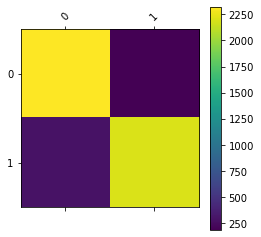

In [139]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap='viridis'):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

plot_confusion_matrix(df_confusion)

## Communicate Results

The "best mode" produced with the Neural Networks was able to predict on test data with a maximum of about 92% accuracy. This is a modest improvement over the Random Forest Classifier's 91% accuracy. Based on the analysis, I recommend the Northwind Trading continues to use the Random Forest Classifier for the time being, pending further research. 

### 1) Data Preparation

A train-test split has already been performed.

Additionally, there is already a pipeline in place that drops some columns and converts all text columns into a numeric format for modeling.

**Your only additional data preparation task is feature scaling.**  Tree-based models like Random Forest Classifiers do not require scaling, but TensorFlow neural networks do.

There are two main strategies you can take for this task:

#### Scaling within the existing pipeline

If you are comfortable with pipelines, this is the more polished/professional route.

1. Make a new pipeline, with a `StandardScaler` as the final step.  You can nest the steps of the previous pipeline inside of this new pipeline
2. Generate a new `X_train_transformed_scaled` by calling `.fit_transform` on the new pipeline
3. Generate a new `X_test_transformed_scaled` by calling `.transform` on the new pipeline

#### Scaling after the pipeline has finished

This is a better strategy if you are not as comfortable with pipelines.

1. Instantiate a `StandardScaler` object
2. Generate a new `X_train_transformed_scaled` by calling `.fit_transform` on the scaler object, after you have called `.fit_transform` on the pipeline
3. Generate a new `X_test_transformed_scaled` by calling `.transform` on the scaler object, after you have called `.transform` on the pipeline

If you are getting stuck at this step, skip it.  The model will still be able to fit, although the performance will be worse.  Keep in mind whether or not you scaled the data in your final analysis.

### 2) Modeling

Build a neural network classifier.  Specifically, use the `keras` submodule of the `tensorflow` library to build a multi-layer perceptron model with the `Sequential` interface.

See the [`tf.keras` documentation](https://www.tensorflow.org/guide/keras/overview) for an overview on the use of `Sequential` models. See the [Keras layers documentation](https://keras.io/layers/core/) for descriptions of the `Dense` layer options.  

1. Instantiate a `Sequential` model
2. Add an input `Dense` layer.  You'll need to specify a `input_shape` = (11275,) because this is the number of features of the transformed dataset.
3. Add 2 `Dense` hidden layers.  They can have any number of units, but keep in mind that more units will require more processing power.  We recommend an initial `units` of 64 for processing power reasons.
4. Add a final `Dense` output layer.  This layer must have exactly 1 unit because we are doing a binary prediction task.
5. Compile the `Sequential` model
6. Fit the `Sequential` model on the preprocessed training data (`X_train_transformed_scaled`) with a b`batch_size` of 50 and `epochs` of 5 for processing power reasons.


### 3) Model Tuning + Feature Engineering

If you are running out of time, skip this step.

Tune the neural network model to improve performance.  This could include steps such as increasing the units, changing the activation functions, or adding regularization.

We recommend using using a `validation_split` of 0.1 to understand model performance without utilizing the test holdout set.

You can also return to the preprocessing phase, and add additional features to the model.

### 4) Model Evaluation

Choose a final `Sequential` model, add layers, and compile.  Fit the model on the preprocessed training data (`X_train_transformed_scaled`, `y_train`) and evaluate on the preprocessed testing data (`X_test_transformed_scaled`, `y_test`) using `accuracy_score`.

### 5) Technical Communication

Write a paragraph explaining whether Northwind Trading Company should switch to using your new neural network model, or continue to use the Random Forest Classifier.  Beyond a simple comparison of performance, try to take into consideration additional considerations such as:

 - Computational complexity/resource use
 - Anticipated performance on future datasets (how might the data change over time?)
 - Types of mistakes made by the two kinds of models

You can make guesses or inferences about these considerations.

**Include at least one visualization** comparing the two types of models.  Possible points of comparison could include ROC curves, colorized confusion matrices, or time needed to train.
